# (Common)Factor Analysis (FA)

#### References

- [Exploratory Factor Analysis](https://www.earthinversion.com/geophysics/exploratory-factor-analysis/)
- [Factor Analysis](https://www.datasklr.com/principal-component-analysis-and-factor-analysis/factor-analysis)

In [33]:
%%capture
!pip install factor_analyzer

In [34]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from sklearn import datasets

## Iris dataset

In [35]:
# load data
X, y = datasets.load_iris(return_X_y=True)
X = pd.DataFrame(data=X, columns=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])
y = pd.Series(y).map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})
# Standardizing the features
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
# display
X_scaled.shape, X.shape, y.shape

((150, 4), (150, 4), (150,))

## Adequacy Test

Before we perform factor analysis, we need to evaluate the “factorability” of our dataset. Factorability means “can we find the factors in the dataset?”. 

There are two methods to check the factorability:

- Bartlett’s Test
- Kaiser-Meyer-Olkin Test

### Bartlett’s Test

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, we should not employ a factor analysis.

In [36]:
chi_square_value,p_value=calculate_bartlett_sphericity(X_scaled)
chi_square_value, p_value

(710.8879087307147, 2.7265151921758875e-150)

### Kaiser-Meyer-Olkin (KMO) Test

It is a statistic that indicates the proportion of variance in our variables that might be caused by underlying factors. High values (close to 1.0) generally indicate that a factor analysis may be useful with our data. If the value is less than 0.50, the results of the factor analysis probably won’t be very useful.

In [37]:
kmo_all,kmo_model=calculate_kmo(X_scaled)
kmo_model

0.5367519348790604

## Number of factors selection

The eigenvalue is a good criterion for determining the number of factors. Generally, an eigenvalue greater than 1 will be considered as selection criteria for the feature.

In [38]:
#EXPLORATORY FACTOR ANALYSIS
fa = FactorAnalyzer(X_scaled.shape[1], rotation=None)
fa.fit(X_scaled)
#GET EIGENVALUES
ev, cfef = fa.get_eigenvalues()
ev

array([2.91849782, 0.91403047, 0.14675688, 0.02071484])

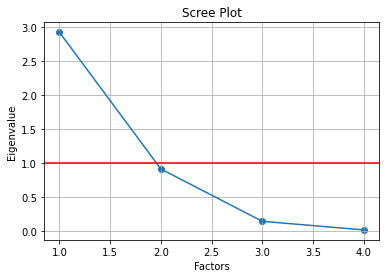

In [39]:
# SCREEPLOT (need pyplot)
plt.scatter(range(1,X_scaled.shape[1]+1),ev)
plt.plot(range(1,X_scaled.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1,c='red')
plt.grid()
plt.show()

## Factor Analysis

In [40]:
# Create factor analysis object and perform factor analysis
num_factors = 2
fa = FactorAnalyzer(num_factors, rotation="varimax", method='minres', use_smc=True)
fa.fit(X_scaled)

FactorAnalyzer(n_factors=2, rotation='varimax', rotation_kwargs={})

#### factor loadings
The factor loading is a matrix which shows the relationship of each variable to the underlying factor. It shows the correlation coefficient for the observed variable and factor. It shows the variance explained by the observed variables (source).

In [41]:
loadings = pd.DataFrame(fa.loadings_, columns=[f'Factor {i}' for i in range(1,num_factors+1)], index=X_scaled.columns)

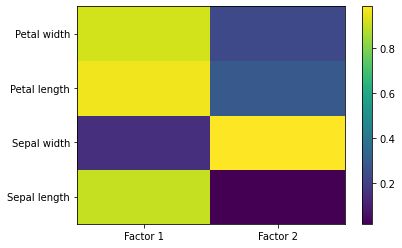

In [42]:
Z=np.abs(loadings.values)
fig, ax = plt.subplots()
c = ax.pcolor(Z)
fig.colorbar(c, ax=ax)
ax.set_yticks(np.arange(loadings.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(loadings.shape[1])+0.5, minor=False)
ax.set_yticklabels(loadings.index.values)
ax.set_xticklabels(loadings.columns.values)
plt.show()

In [50]:
# loadings with practise significance
temp = loadings[np.abs(loadings)>=0.4].sort_values(loadings.columns.tolist())
temp["communalities"] = fa.get_communalities()
temp

,Factor 1,Factor 2,communalities
Sepal length,0.901205,NaN,0.812491
Petal width,0.921401,NaN,0.995205
Petal length,0.964153,NaN,1.010600
Sepal width,NaN,0.986195,0.903383


In [66]:
# statistical significance
nsample = X_scaled.shape[0]
v = np.array([[.3, 350], 
             [.35,250],
             [.40,200],
             [.45,150],
             [.5,120],
             [.55,100],
             [.60,85],
             [.65,70],
             [.7,60],
             [.75,50]])
dfss = pd.DataFrame(v, columns = ["factor_loading", "min_sample_size"])
max_factor_loading_without_significance = dfss[dfss.min_sample_size>nsample].factor_loading.max()
print(f'Factor loading with values lower and equal than {max_factor_loading_without_significance} are not statistically significatives.')
loadings[loadings<=max_factor_loading_without_significance]

Factor loading with values lower and equal than 0.4 are not statistically significatives.


,Factor 1,Factor 2
Sepal length,NaN,0.017890
Sepal width,-0.150413,NaN
Petal length,NaN,-0.284619
Petal width,NaN,-0.233245


In [44]:
# are there cross loadings?
loadings[(np.abs(loadings)>=0.4)].isnull().sum(axis = 1) == 0

Sepal length    False
Sepal width     False
Petal length    False
Petal width     False
dtype: bool

#### variance for each factor

In [45]:
fa_variances = pd.DataFrame(fa.get_factor_variance(), columns = [f'Factor {i}' for i in range(1,num_factors+1)], index = ["SS Loadings", "Porportion var", "Cumulative var"])
fa_variances

,Factor 1,Factor 2
SS Loadings,2.613367,1.108312
Porportion var,0.653342,0.277078
Cumulative var,0.653342,0.930420


In [46]:
print(f"Total cumulative variance explained by the all factors = {fa.get_factor_variance()[2][-1] * 100.}%")

Total cumulative variance explained by the all factors = 93.04199356626795%


#### Conclusiones

- Segun el primer factor, sepal length y petal guardan mucha informacion en comun mientras que sepal width va por libre.
- El analisis explica gran parte de la variabilidad de los datos (93%).